In [1]:
%matplotlib inline

/Users/NIGG/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/NIGG/.matplotlib/matplotlibrc", line #515
  (fname, cnt))
/Users/NIGG/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/NIGG/.matplotlib/matplotlibrc", line #516
  (fname, cnt))


In [2]:
import numpy as np
import pandas as pd

#　統計用ツール
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from patsy import dmatrices

#　自作の空間統計用ツール
from spatialstat import *

#描画
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
import seaborn as sns
sns.set(font=['IPAmincho'])

#深層学習
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

from makedata import makedata

In [3]:
data = pd.read_csv("TokyoSingle.csv")
data = data.dropna()

In [4]:
datas = makedata(data)

In [5]:
datas = datas[datas['12世田谷区'] == 1][0:5000]

In [6]:
class CAR(Chain):
    def __init__(self, unit1, unit2, unit3, col_num):
        self.unit1 = unit1
        self.unit2 = unit2
        self.unit3 = unit3
        super(CAR, self).__init__(
            l1 = L.Linear(col_num, unit1),
            l2 = L.Linear(self.unit1, self.unit1),
            l3 = L.Linear(self.unit1, self.unit2),
            l4 = L.Linear(self.unit2, self.unit3),
            l5 = L.Linear(self.unit3, self.unit3),
            l6 = L.Linear(self.unit3, 1),
        )
    
    def __call__(self, x, y):
        fv = self.fwd(x, y)
        loss = F.mean_squared_error(fv, y)
        return loss
    
    def fwd(self, x, y):
        h1 = F.sigmoid(self.l1(x))
        h2 = F.sigmoid(self.l2(h1))
        h3 = F.sigmoid(self.l3(h2))
        h4 = F.sigmoid(self.l4(h3))
        h5 = F.sigmoid(self.l5(h4))
        h6 = self.l6(h5)
        return h6

In [7]:
class OLS_DLmodel(object):
    def __init__(self, data, vars, bs=200, n=1000):
        self.vars = vars
        eq = fml_build(vars)
        y, X = dmatrices(eq, data=datas, return_type='dataframe')
        self.y_in = y[:-n]
        self.X_in = X[:-n]
        self.y_ex = y[-n:]
        self.X_ex = X[-n:]
        
        self.logy_in = np.log(self.y_in)
        self.logy_ex = np.log(self.y_ex)
        
        self.bs = bs
        
        self.ido_in = np.array([datas['X'][:-n]])
        self.keido_in = np.array([datas['Y'][:-n]])
        self.W_in = ((self.ido_in.T - self.ido_in)**2 + 
                    (self.keido_in.T - self.keido_in)**2)
        N = np.array(np.matrix(self.W_in)*np.matrix(np.ones(len(self.ido_in[0]))).T)
        self.W_in = self.W_in/N
        self.ido_ex = np.array([datas['X'][-n:]])
        self.keido_ex = np.array([datas['Y'][-n:]])

    def OLS(self):
        X_in = self.X_in
        X_in = X_in.drop(['X', 'Y'], axis=1)
        model = sm.OLS(self.logy_in, X_in, intercept=False)
        self.reg = model.fit()
        print(self.reg.summary())
        df = (pd.DataFrame(self.reg.params)).T
        df['X'] = 0
        df['Y'] = 0
        self.reg.params = pd.Series((df.T)[0])
        
    def directDL(self, ite=100, bs=200, add=False):
        logy_in = np.array(self.logy_in, dtype='float32')
        X_in = np.array(self.X_in, dtype='float32')

        y = Variable(logy_in)
        x = Variable(X_in)

        num, col_num = X_in.shape
        
        if add is False:
            self.model1 = CAR(15, 15, 5, col_num)
        
        optimizer = optimizers.SGD()
        optimizer.setup(self.model1)

        for j in range(ite):
            sffindx = np.random.permutation(num)
            for i in range(0, num, bs):
                x = Variable(X_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                y = Variable(logy_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                self.model1.zerograds()
                loss = self.model1(x, y)
                loss.backward()
                optimizer.update()
            if j % 1000 == 0:
                loss_val = loss.data
                print('epoch:', j)
                print('train mean loss={}'.format(loss_val))
                print(' - - - - - - - - - ')
                
        y_ex = np.array(self.y_ex, dtype='float32').reshape(len(self.y_ex))
        X_ex = np.array(self.X_ex, dtype='float32')
        X_ex = Variable(X_ex)

        logy_pred =  self.model1.fwd(X_ex, X_ex).data
        y_pred = np.exp(logy_pred)
        error = y_ex - y_pred.reshape(len(y_pred),)
        plt.hist(error[:])
        
    def DL(self, ite=100, bs=200, add=False):
        y_in = np.array(self.y_in, dtype='float32').reshape(len(self.y_in))
                                                            
        resid = y_in - np.exp(self.reg.predict())
        resid = np.array(resid, dtype='float32').reshape(len(resid),1)
        
        X_in = np.array(self.X_in, dtype='float32')

        y = Variable(resid)
        x = Variable(X_in)

        num, col_num = X_in.shape
        
        if add is False:
            self.model1 = CAR(10, 10, 3, col_num)
            
        optimizer = optimizers.Adam()
        optimizer.setup(self.model1)

        for j in range(ite):
            sffindx = np.random.permutation(num)
            for i in range(0, num, bs):
                x = Variable(X_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                y = Variable(resid[sffindx[i:(i+bs) if (i+bs) < num else num]])
                self.model1.zerograds()
                loss = self.model1(x, y)
                loss.backward()
                optimizer.update()
            if j % 1000 == 0:
                loss_val = loss.data
                print('epoch:', j)
                print('train mean loss={}'.format(loss_val))
                print(' - - - - - - - - - ')
            
    def predict(self):
        y_ex = np.array(self.y_ex, dtype='float32').reshape(len(self.y_ex))
        
        X_ex = np.array(self.X_ex, dtype='float32')
        X_ex = Variable(X_ex)
        resid_pred =  self.model1.fwd(X_ex, X_ex).data  
        print(resid_pred[:10])
        
        self.logy_pred = np.matrix(self.X_ex)*np.matrix(self.reg.params).T
        self.error1 = np.array(y_ex - np.exp(self.logy_pred.reshape(len(self.logy_pred),)))[0]
        
        self.pred = np.exp(self.logy_pred) + resid_pred
        self.error2 = np.array(y_ex - self.pred.reshape(len(self.pred),))[0]
        
    def compare(self):
        plt.hist(self.error1)
        plt.hist(self.error2)

In [8]:
vars = ['P', 'S', 'L', 'R', 'RW', 'A', 'TS', 'TT', 'WOOD', 'SOUTH', 'CMD', 'IDD', 'FAR', 'X', 'Y']
#vars += vars + list(TDQ.columns)

In [9]:
model = OLS_DLmodel(datas, vars)

In [10]:
model.OLS()

                            OLS Regression Results                            
Dep. Variable:                      P   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1130.
Date:                Mon, 13 Feb 2017   Prob (F-statistic):               0.00
Time:                        00:10:27   Log-Likelihood:                 1308.3
No. Observations:                4000   AIC:                            -2591.
Df Residuals:                    3987   BIC:                            -2509.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.7986      0.038    228.864      0.0

In [11]:
model.DL(ite=10, bs=200)

epoch: 0
train mean loss=3400492.25
 - - - - - - - - - 


In [12]:
model.predict()

[[ 0.53898537]
 [ 0.53707778]
 [ 0.53898561]
 [ 0.53515244]
 [ 0.53898513]
 [ 0.53898561]
 [ 0.53898299]
 [ 0.53882819]
 [ 0.53802216]
 [ 0.53673291]]


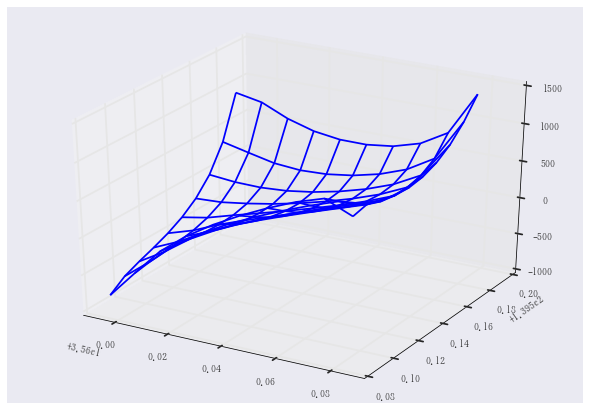

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

X = model.X_ex['X'].values
Y = model.X_ex['Y'].values

Xs = np.linspace(min(X),max(X),10)
Ys = np.linspace(min(Y),max(Y),10)

error = model.error1
Xgrid, Ygrid = np.meshgrid(Xs, Ys)
Z = LL(X, Y, Xs, Ys, error)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(Xgrid,Ygrid,Z) #<---ここでplot

plt.savefig("Main1.jpg")
plt.show()